In [8]:
import pandas as pd
from utils import randomforest
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import disjointification
plt.style.use(['science', 'notebook'])

In [9]:
save_point = Path(r"\model\08_08_2023__14_15_26\08_08_2023__14_15_26.pkl") # savepoint with full dataset and correlation threshold 0.4
disjointification_model = disjointification.from_file(save_point)
disjointification_model.describe()
disjointification_model.features_df.head()

Disjointification Test Description
features data: (3069, 9259)
labels data: (3069, 2)
regression label: Lympho
classification label: ER
correlation method regression: pearson
correlation method regression: kendall
min num of features to keep in disjointification: 500
correlation threshold: 0.4
last save point: \model\08_08_2023__14_15_26\08_08_2023__14_15_26.pkl
number of features kept in disjointification: lin 500, log 500


,A2M,A4GNT,AAAS,AACS,AADAC,AAK1,AAMP,AARS,AASDHPPT,AASS,...,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN5A,ZW10,ZWINT,ZXDA,ZXDC,ZYX,ZZEF1
samplename,,,,,,,,,,,,,,,,,,,,,
F1,-1.098234,-0.615048,-1.670827,-0.539020,0.098325,-1.989513,-0.376823,0.439949,-0.990079,-1.715000,...,-0.271914,-0.607976,-0.349919,-1.740601,0.586037,-0.067762,2.314161,0.481213,-0.277116,-1.183044
F2,0.110096,-0.615048,0.248934,0.032084,0.262344,-1.211690,-0.480422,-0.933772,-0.392950,-0.401287,...,0.316885,-0.130563,1.064711,0.578536,-0.270144,-0.381822,0.239147,-1.087827,1.399415,-1.203251
F3,-1.779393,-0.615048,-0.422635,0.392158,-0.711190,-0.210792,1.145994,1.938679,-0.093394,-2.103685,...,-2.060746,-1.840604,-1.081964,-0.807412,1.520787,1.682110,-1.593300,0.110658,0.481292,-0.641483
F4,0.268360,-0.615048,0.236302,0.563540,-0.373168,-0.839605,0.753860,1.562852,0.933071,0.329659,...,-0.812436,-0.836057,0.505783,-0.035067,-0.184722,1.094690,1.002772,0.294238,0.449014,0.854496
F5,0.616851,-0.615048,-0.988261,-0.083663,0.067739,-0.732227,-0.760831,-0.655655,-0.962107,1.256546,...,1.349677,-0.114500,0.833477,0.179142,-0.989962,-2.177457,1.244214,1.526451,0.095333,0.700526


## Random Forest Model

In [10]:
rf_model_pkl_path = Path("rf_model/rf_08_29_2023__20_41_33.pkl" )
rf_cls_model_pkl_path = Path("rf_cls_model/rf_cls_08_29_2023__21_28_52.pkl")
rf_model = randomforest.from_file(rf_model_pkl_path)
rf_cls_model = randomforest.from_file(rf_cls_model_pkl_path)

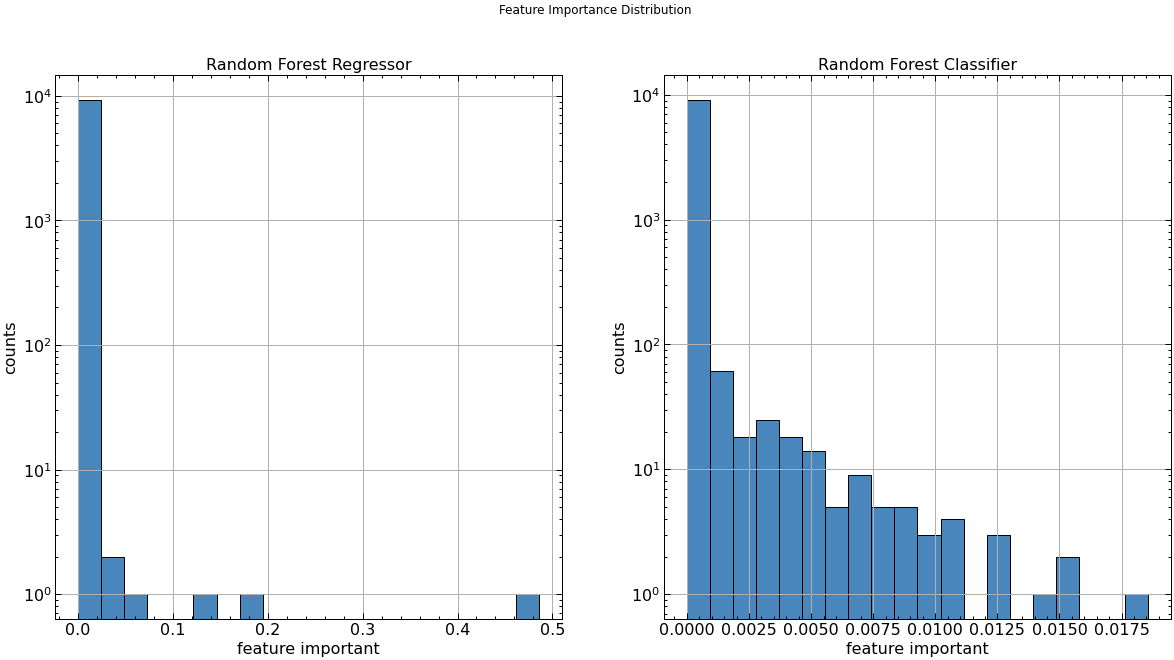

In [11]:
randomforest.show_feature_importance(rf_model, rf_cls_model)

In [6]:
sorted_features_by_importance = sorted(zip(rf_model.rf.feature_importances_, rf_model.rf.feature_names_in_), reverse=True)

[(0.48625534798641046, 'CD3E'),
 (0.193427583766068, 'ACAP1'),
 (0.12169596621706452, 'LCK'),
 (0.056419132046539214, 'CD247'),
 (0.04270592122299806, 'IL2RG'),
 (0.031006995163227715, 'MAP4K1'),
 (0.008072258551859739, 'CD48'),
 (0.0064691128338205655, 'CD3G'),
 (0.006070589519678555, 'SLAMF1'),
 (0.001701456720084021, 'CD2'),
 (0.001636961005517574, 'PRKCB'),
 (0.0016198133360569012, 'IKZF3'),
 (0.0013977245363254699, 'CCR5'),
 (0.0013558511535523919, 'SASH3'),
 (0.0013027508604819434, 'CSF2RB'),
 (0.0011749570321998104, 'PRKCQ'),
 (0.001133227169770724, 'RAC2'),
 (0.000774975884486656, 'PTPRC'),
 (0.000773650449275941, 'SP140'),
 (0.0006833468110797022, 'LY9'),
 (0.0006385176550253441, 'BIN2'),
 (0.0005998246430413717, 'ITK'),
 (0.000584336591643819, 'ARHGAP25'),
 (0.0005430210124000068, 'LRMP'),
 (0.0005311482096721933, 'SLAMF7'),
 (0.000501303655952737, 'PTPN7'),
 (0.0004702314046172687, 'CD27'),
 (0.00046731998491402594, 'IRF4'),
 (0.00044015807948610044, 'SIT1'),
 (0.00042937312